# 使用 Logistic 回归对莆田系医院名称进行分类

In [1]:
import numpy as np
import jieba
from scipy.sparse import *
from scipy.sparse.linalg import svds
from matplotlib import pyplot

## 生成数据集

In [2]:
label = []
dataset_raw = []
dataset_segmented = []
for filename, label_value in {"white_list.txt":1, "black_list.txt":-1}.items():
    with open(filename,"r") as fp:
        for hospital_name in fp.readlines():
            hospital_name = hospital_name.replace("\n","")
            dataset_segmented.append([w for w in  jieba.cut(hospital_name)]) 
            dataset_raw.append(hospital_name)
            label.append(label_value)
words = list(set([y for x in dataset_segmented for y in x]))
words_map = { w:i for i,w in enumerate(words)}

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.137 seconds.
Prefix dict has been built succesfully.


In [3]:
il = []
jl = []
vl = []
for i, value in enumerate(dataset_segmented):
    for j in (words_map[w] for w in value):
        il.append(i)
        jl.append(j)
        vl.append(1.0)
spX = coo_matrix((np.array(vl),(np.array(il),np.array(jl))), shape=(len(label),len(words)))

In [4]:
import random
import pandas
import itertools
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    绘制混淆矩阵的函数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()
    
def plot_confusion_matrix_by_model(model,x,y,title="Model Confusion Matrix",normalize=False):
    plot_confusion_matrix(confusion_matrix(y, model.predict(x)), [-1, 1], normalize=normalize, title=title)
    

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
X_train,X_test, y_train, y_test = train_test_split(spX, label, test_size=0.08, random_state=1)

## 指定模型开始训练
需要注意的是，我们的模型秉承“宁可错杀一千，也不要放过一个”的目标，需要将负样本的权重适当调整大一些。

In [6]:
import time
start_tick = time.time()
model = LogisticRegressionCV(
    Cs=[10 ** x for x in range(-5, 5)],
    cv=8,
    solver="liblinear",
    class_weight={
        1:1,
        -1:10
    },
    n_jobs=-1
)
model.fit(X_train, y_train)
duration = time.time() - start_tick
print("训练完成，训练数据尺寸：{} 耗时：{}".format(X_train.shape, duration))

训练完成，训练数据尺寸：(13955, 7155) 耗时：3.4732444286346436


## 结果评价
绘制混淆矩阵

Normalized confusion matrix
[[0.95402299 0.04597701]
 [0.01863354 0.98136646]]


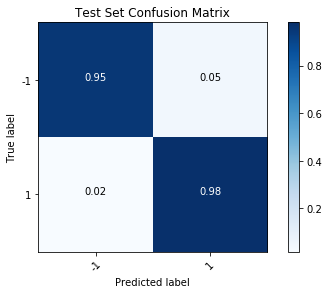

Normalized confusion matrix
[[1.         0.        ]
 [0.00896237 0.99103763]]


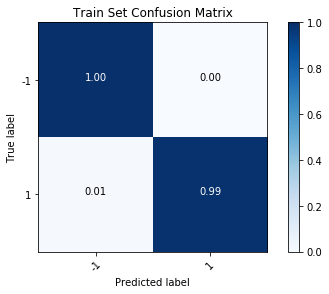

In [7]:
plot_confusion_matrix_by_model(model,X_test,y_test,title="Test Set Confusion Matrix",normalize=True)
plot_confusion_matrix_by_model(model,X_train,y_train,title="Train Set Confusion Matrix",normalize=True)

绘制ROC曲线

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


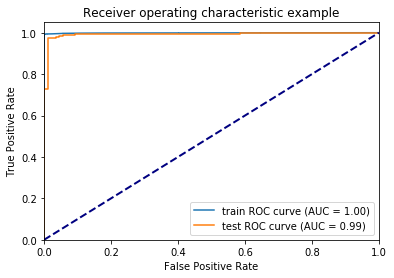

In [8]:
from sklearn.metrics import roc_curve, auc
pyplot.figure()
pyplot.cla()
pyplot.hold(True)
lw = 2
for x_data,y_data,label_info in [(X_train,y_train,"train"),(X_test,y_test,"test")]:
    y_cls_prob = model.decision_function(x_data)
    fpr,tpr,_ = roc_curve(y_data, y_cls_prob)
    roc_auc = auc(fpr, tpr)
    pyplot.plot(fpr, tpr, label='%s ROC curve (AUC = %0.2f)' % (label_info, roc_auc))
pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Receiver operating characteristic example')
pyplot.legend(loc="lower right")
pyplot.hold(False)

In [9]:
w = model.coef_[0]
reI = np.argsort(w)

In [10]:
print([words[i] for i in reI[:15]])

['慧慈', '凉山', '玛莉亚', '爱德华', '济南', '阳光', '国丹', '九州', '天骄', '莆田', '江南', '青羊区', '南亚', '妇科', '中骏']


In [11]:
print([words[i] for i in reI[-15:]])

['264', '闵行', '中国人民武装警察部队', '钢铁', '中国人民解放军', '分院', '协合', '护理', '铁路分局', '医学院', '四川省', '职工', '乳房', '地段', '妇幼保健']


In [12]:
def predict(hospital_name:str):
    words_index = [words_map[w] for w in  jieba.cut(hospital_name) if w in words_map]
    il = [0 for _ in words_index]
    vl = [1 for _ in words_index]
    result = model.predict(
        coo_matrix(
            (
                np.array(vl),
                (
                    np.array(il),
                    np.array(words_index)
                )
            ), 
            shape=(1,len(words))
        )
    )
    if result>0:
        print("Normal") 
    else:
        print("Fuck") 
    
predict("上海玛丽女子医院")
predict("上海市中医医院")
predict("京州市阳光医院")
predict("汉东省人民医院")

Fuck
Normal
Fuck
Normal


In [13]:
from sklearn.externals import joblib
joblib.dump(model,"slogistic.m")

['slogistic.m']

In [15]:
import json
with open("words_map.json" ,"w") as fp:
    fp.write(json.dumps(words_map))